# Comparación de modelos



In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")

import matplotlib.pyplot as plt
import numpy as np


import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))

from utils import powergrid

In [2]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"
results_save_path = "../experimentos_split/results"


In [3]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="regression")
_,_,_ =loader.process()
limit = 300


Processing dataset...
Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:

## Comparación

In [134]:
from importlib import reload
import utils.trainer
utils.trainer=reload(utils.trainer)

In [135]:
from importlib import reload
import utils.models
utils.models=reload(utils.models)

In [136]:
from utils import pygt_loader
import os
import torch
from utils.utils_graph import format_plot
from utils.utils_graph import reconstruir_predictions, plot_training_and_eval_losses, plot_predictions, plot_multiple_models

from utils.trainer import  TrainerAGCRN, TrainerDryGrEncoder, TrainerLSTMModel, TrainerMPNNLSTM, TrainerMSTGCN, TrainerDCRNN
from utils import trainer
dtype = torch.float
import ast
device = torch.device("mps")
import utils.models

In [6]:
problem = "gen_trip"
path_problem_results = os.path.join(results_save_path, problem)
print(path_problem_results)

../experimentos_split/results/gen_trip


In [7]:
dataset, situations = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)

n_div_gt = loader.div


Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  184


In [157]:
def process_model(name, path_problem_results, dataset, dataloader_params_nobatch):

    dataloader_params_nobatch['use_batch'] = False
    dataloader_params = dataloader_params_nobatch.copy()
    dataloader_params['use_batch'] = True


    n_nodes =dataset.features[0].shape[0]
    n_target = dataset.targets[0].shape[1]
    n_features = dataset[0].x.shape[1]
    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

    df = pd.read_csv(os.path.join(path_problem_results, "results.csv"))
    if name not in df['Modelo'].values:
        raise ValueError("Modelo no tiene resultados en el directorio de resultados")
    params_prelim = df[df['Modelo']==name]['Params'].values[0]
    try:
        params = ast.literal_eval(params_prelim) if isinstance(params_prelim, str) else {}
    except ValueError:
        params = {}

    print(params)
    if name =='DyGrEncoder':
        model= utils.models.DyGrEncoderModel("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, num_conv=params['conv'], num_lstm=params['lstm'], aggr=params['aggr'])
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerDryGrEncoder(model, dataset, device, f"./results/{problem}", dataloader_params_nobatch, verbose=False)

    elif name =='AGCRN':
        model = utils.models.AGCRNModel(n_features=n_features, n_nodes=n_nodes, embedding_dim=params['embedding'],hidden_size=params['hidden'],k=params['K'], n_target=n_target, name="AGCRN")
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerAGCRN(model, dataset,device, f"./results/{problem}", dataloader_params, verbose=False)

    #No hemos hecho ajuste de parámetros
    elif name =='LSTM':
        model = utils.models.LSTMModel(name="LSTM", node_features=n_features, node_count=n_nodes, n_target=n_target, hidden_size=50, num_layers=2)
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerLSTMModel(model, dataset,device, f"./results/{problem}", dataloader_params, batch=True, verbose=False)
        
    elif name =='LSTM_NOBATCH':
        model = utils.models.LSTMModel(name="LSTM_NOBATCH", node_features=n_features, node_count=n_nodes, n_target=n_target, hidden_size=50, num_layers=2)
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerLSTMModel(model, dataset,device, f"./results/{problem}", dataloader_params_nobatch, batch=False, verbose=False)

    elif name == "MPNN_LSTM":
        model = utils.models.MPNNLSTMModel("MPNN_LSTM", node_features=n_features, node_count=n_nodes, n_target=n_target, hidden_size=params['hidden_size'], window=1, dropout=params['dropout'])
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerMPNNLSTM(model, dataset,device, f"./results/{problem}", dataloader_params_nobatch, verbose=False)

    elif name == "MSTGCN":
        model = utils.models.MSTGCNModel("MSTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=params['nb_block'], hidden = params['hidden'],k=2, nb_chev_filter = params['nb_chev_filter'], nb_time_filter =params['nb_time_filter'], time_strides = params['time_strides'])
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerMSTGCN(model, dataset,device, f"./results/{problem}", dataloader_params_nobatch, verbose=False)
    
    elif name == "DCRNN":
        model = utils.models.DCRNNModel("DCRNN",node_features = n_features, node_count=n_nodes, n_target=n_target, hidden_dim=params["hidden"])
        print(os.path.join(path_problem_results, f"{name}.pt"))
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerDCRNN(model, dataset,device, f"./results/{problem}", dataloader_params_nobatch, verbose=False)
    
    elif name =="EvolveGCN":
        model = utils.models.EvolveGCNModel("EvolveGCN", node_features=n_features, node_count=n_nodes, n_target=n_target)
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerDCRNN(model, dataset,device, f"./results/{problem}", dataloader_params_nobatch, verbose=False)
    
    elif name =="ASTGCN":
        model = utils.models.ASTGCNModel("ASTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=params['nb_block'], hidden_size = params['hidden'],k=2, nb_chev_filter = params['nb_chev_filter'], nb_time_filter =params['nb_time_filter'], time_strides = params['time_strides'])
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerMSTGCN(model, dataset,device, f"./results/{problem}", dataloader_params_nobatch, verbose=False)

    else:
        raise ValueError("Modelo no encontrado")
    return trainer


In [138]:
dataloader_params = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":False
}

In [158]:
models_analysis = [ "AGCRN","LSTM"]

predictions = {}
real = {} #Si todos los modelos van sin batch, no hace falta guarsar todos, pero lo ponemos por si acaso
for model_name in models_analysis:
    print("\n\nModelo: ", model_name)
    trainer = process_model(model_name, path_problem_results, dataset, dataloader_params)
    _,_,_,preds, reals = trainer.test()
    predictions[model_name] = preds
    real[model_name] = reals




Modelo:  AGCRN
{'hidden': 10, 'K': 10, 'embedding': 3}

==================== TEST INFO ===================



In [146]:
from importlib import reload

utils_graph =reload(utils.utils_graph)
from utils.utils_graph import plot_predictions, plot_multiple_models

[19, 20, 5, 22, 4, 21, 16, 13]


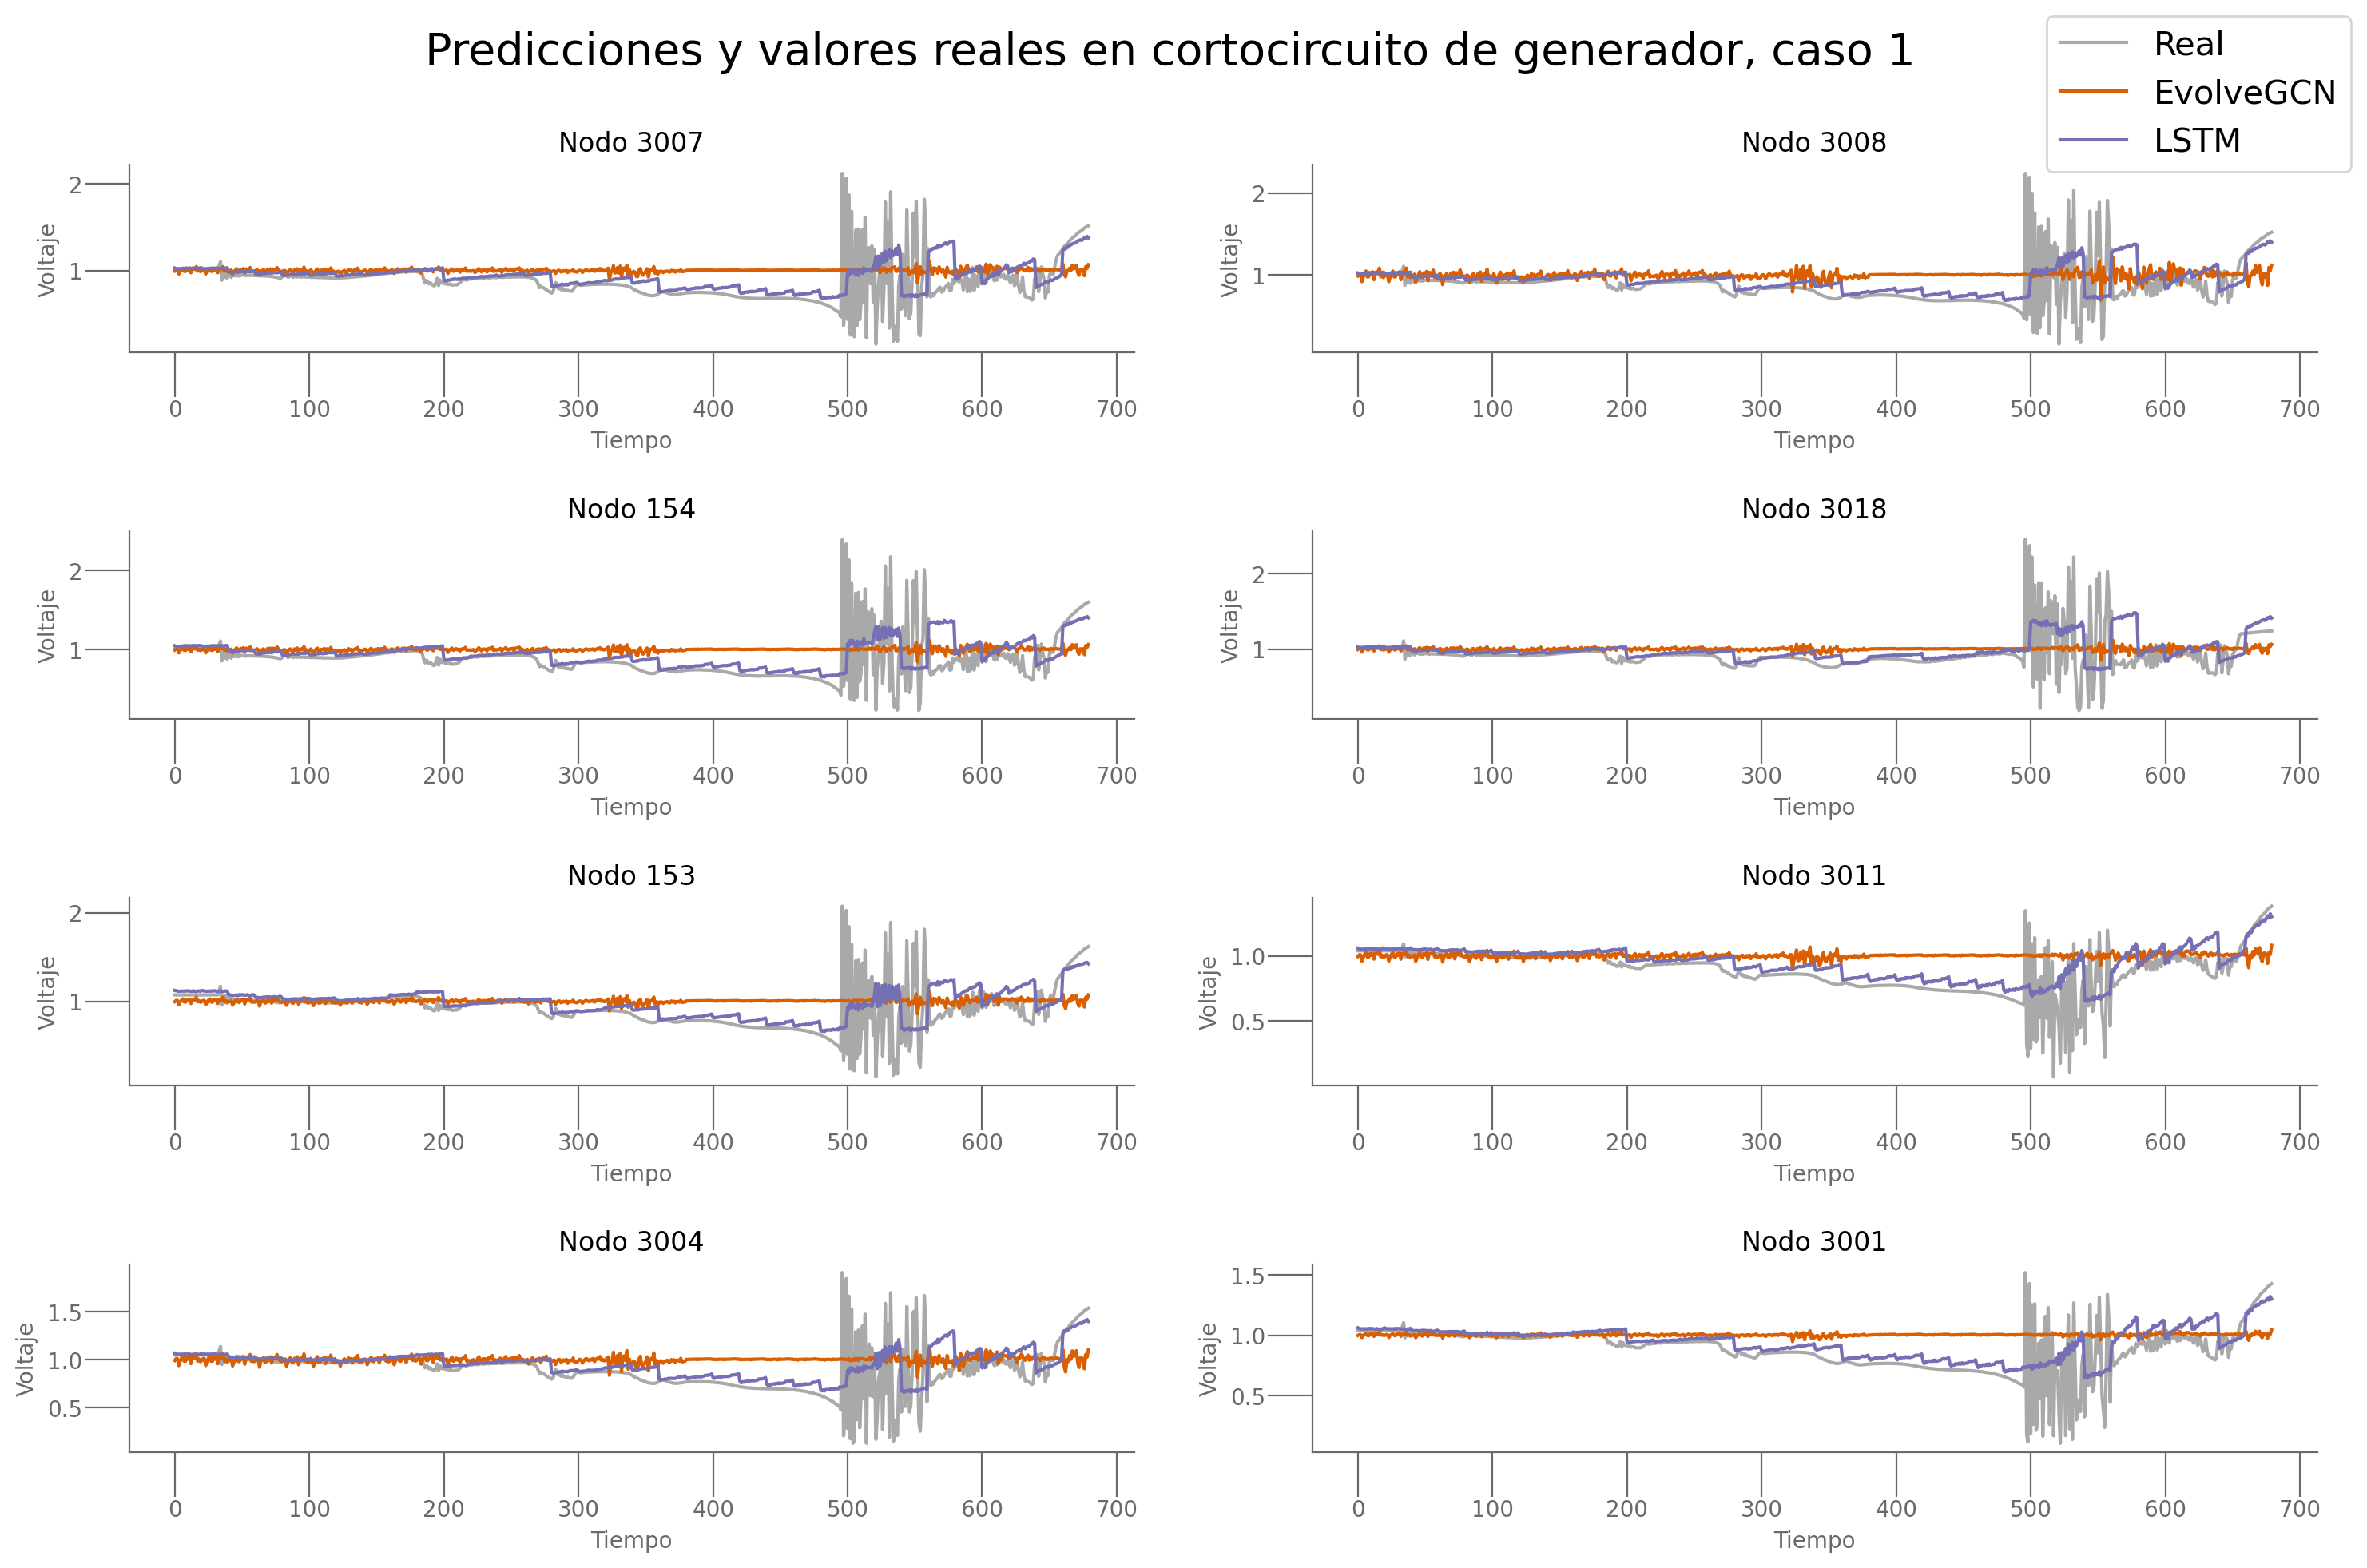

In [148]:
predictions_list= [value for value in predictions.values()]
real_list = [value for value in real.values()]
num_situations_test = int(len(trainer.loader['test'])/n_div_gt)

plot_multiple_models(predictions_list, real_list[0], n_target=dataset.targets[0].shape[1], n_situation=1, n_div=n_div_gt, problem="cortocircuito de generador", names_models = models_analysis, info_situation = loader.info_problem[-num_situations_test:])


### Modelo único

In [14]:
model_name = "MPNN_LSTM" #MPNN_LSTM, AGCRN, LSTM, DyGrEncoder
trainer = trainer = process_model(model_name, path_problem_results, dataset, dataloader_params)
_,_,_,preds, reals = trainer.test()



==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.045889, test r2score -18.247558


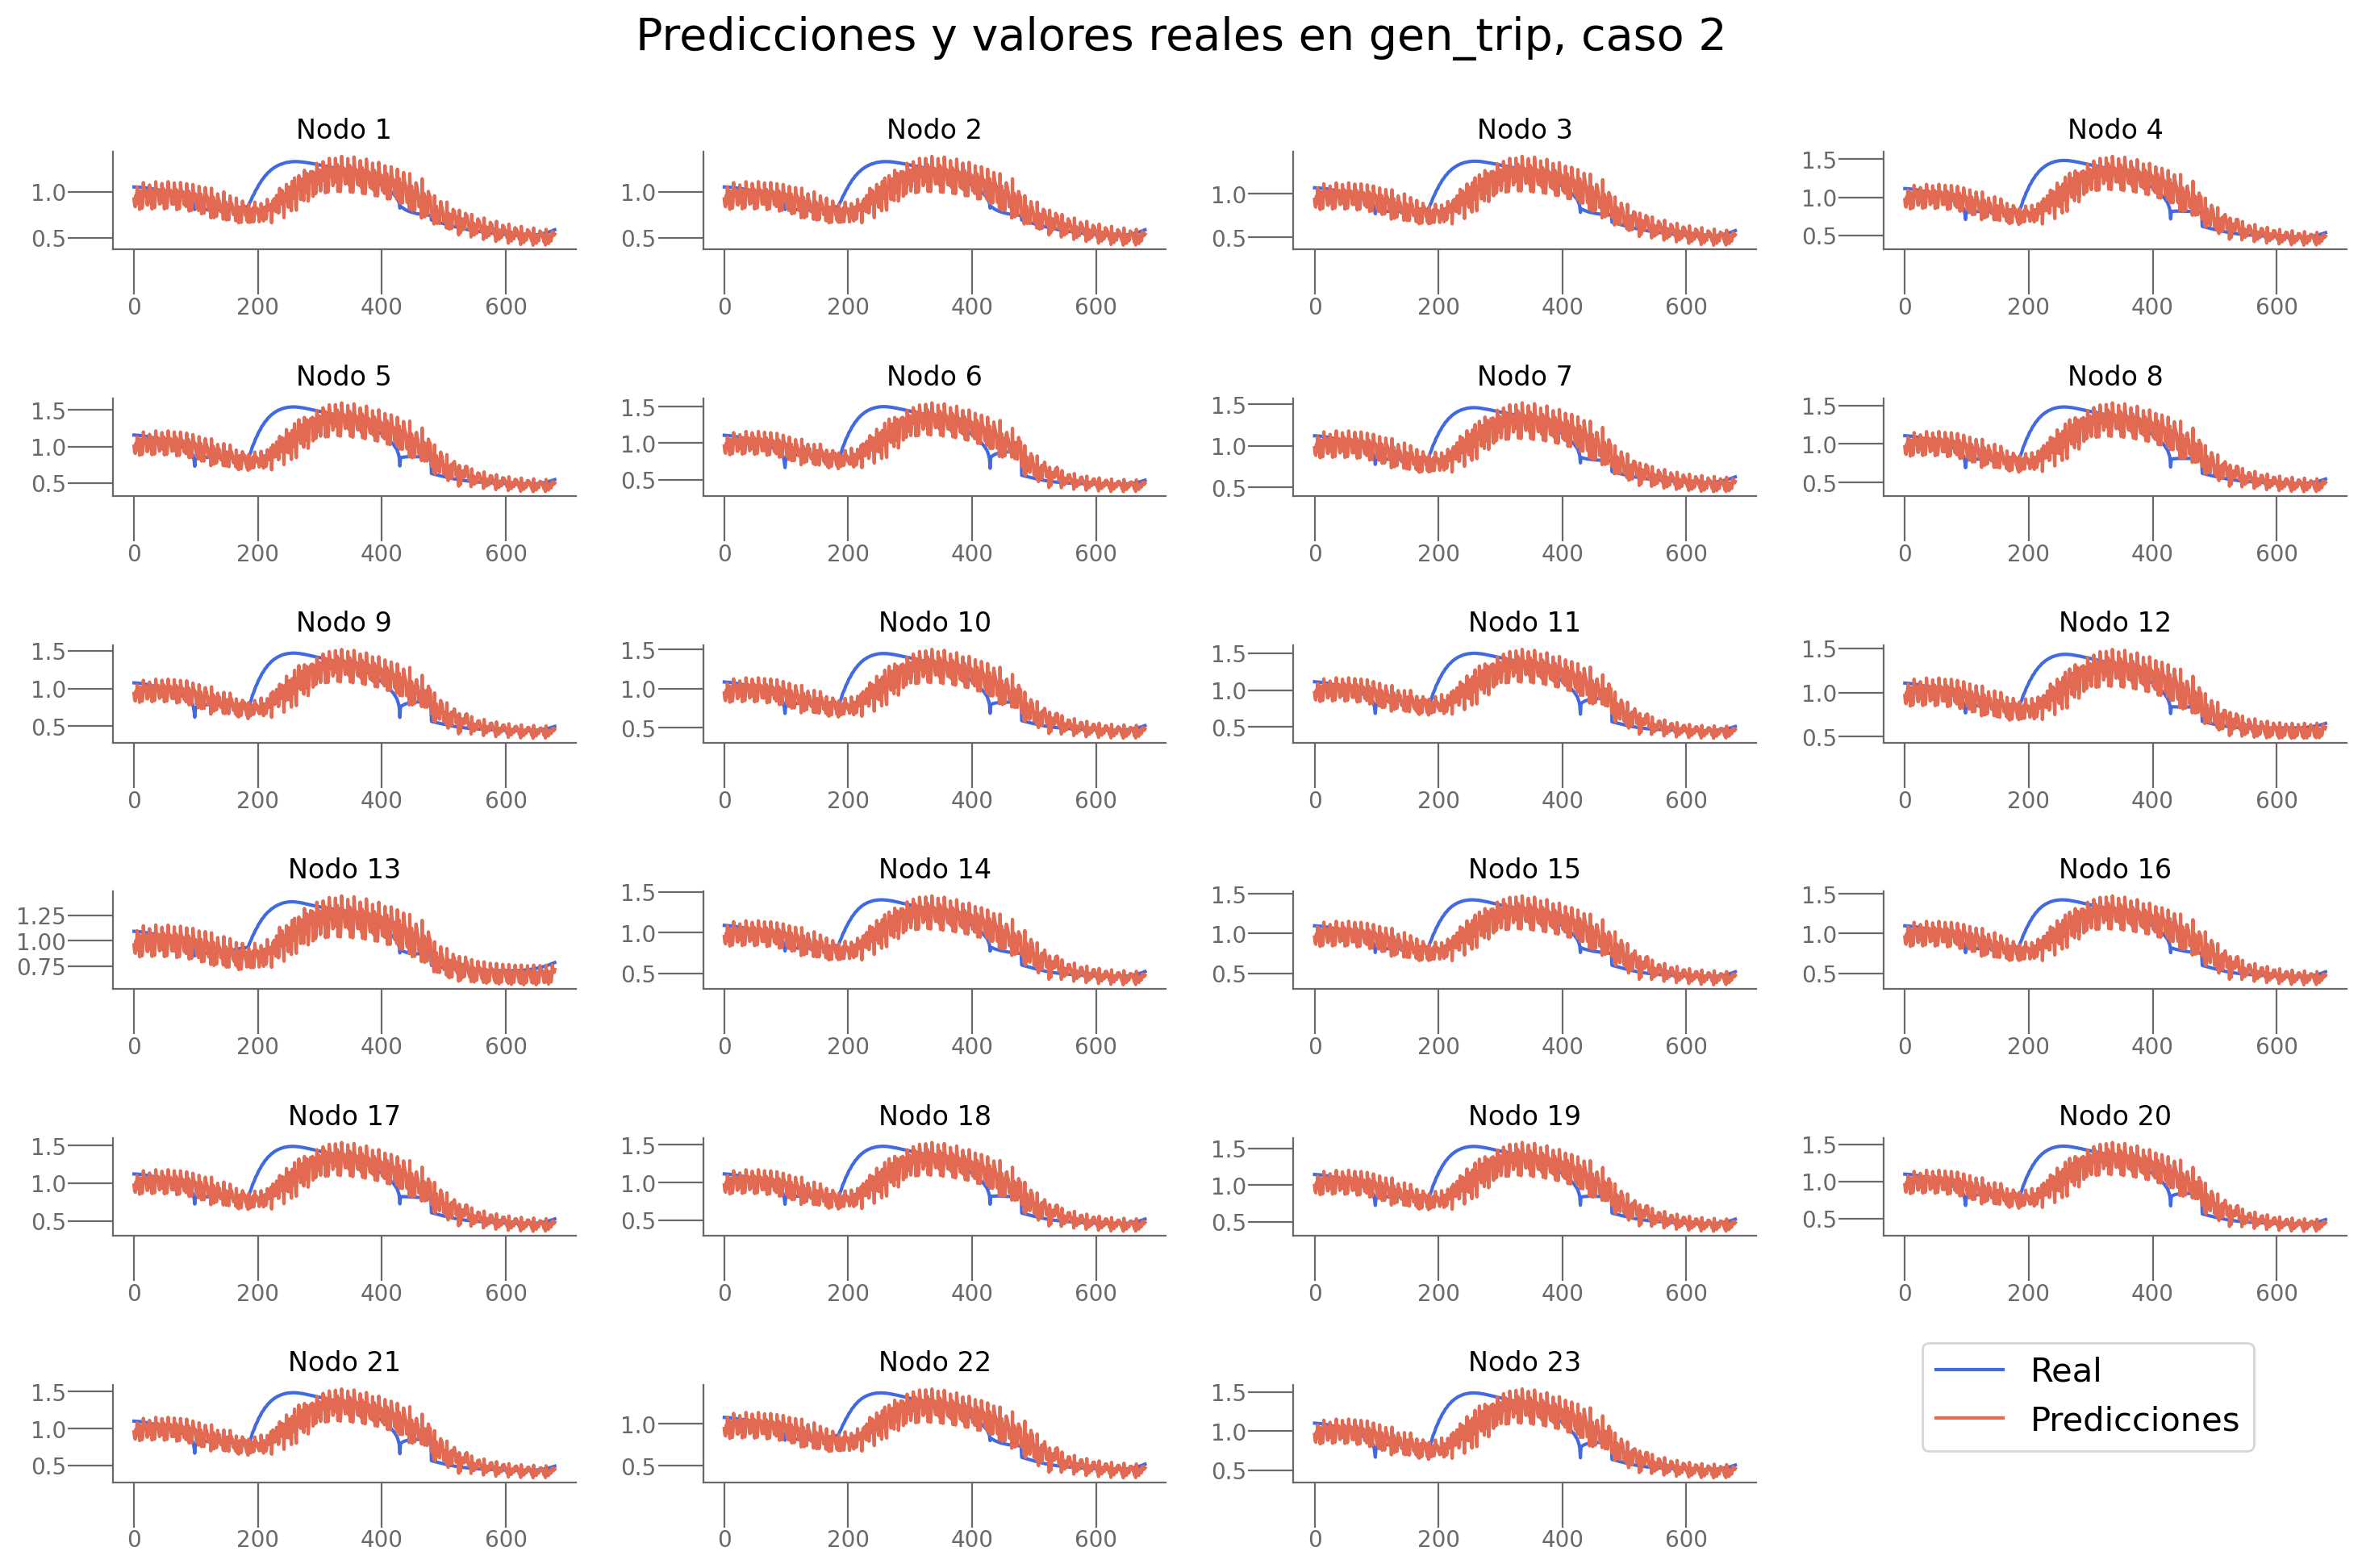

In [15]:
plot_predictions(preds,reals,  n_target=dataset.targets[0].shape[1], n_situation=2, n_div=n_div_gt, problem=problem)

### Tablas de resultados

In [ ]:
problem = "gen_trip"
path_problem_results = os.path.join(results_save_path, problem)
print(path_problem_results)

../experimentos_split/results/gen_trip


In [19]:
df = pd.read_csv(path_problem_results+'/results.csv')
df.sort_values(by='Loss_tst')

,Modelo,Params,Fichero_resultados_experimento,Loss_tst,R2_tst,Loss_nodes,R2_eval,Loss_eval,Loss_final
3,DyGrEncoder,"{'aggr': 'add', 'conv': 1, 'lstm': 1}",./results/gen_trip/ajustes/DryGrEncoder_result...,0.006246,-1.204836,[[0.00222953 0.00414274 0.00527185 0.00363695 ...,-1.286139,0.008926,0.006838
2,LSTM_NOBATCH,NaN,NaN,0.007437,-1.985579,[0.00509721 0.00360723 0.00449464 0.00795687 0...,-1.845531,0.009937,0.009110
0,LSTM,NaN,NaN,0.007638,0.204209,[0.00403222 0.0036478 0.00494586 0.00812658 0...,0.341164,0.009765,0.008689
4,AGCRN,"{'hidden': 5, 'K': 2}",./results/gen_trip/ajustes/AGCRN_results.csv,0.008500,0.207796,[0.00447821 0.00441905 0.00496255 0.00878396 0...,0.243349,0.011286,0.009918
1,MPNN_LSTM,"{'hidden_size': 16, 'dropout': 0.2}",./results/gen_trip/ajustes/MPNNLSTM_results.csv,0.045889,-18.247558,"[0.04005108401179314, 0.03960233926773071, 0.0...",-16.743964,0.052820,0.059339
